# Homework 3 :Learning d'un Feedforward Neural Network


*Etudiant* : BAHOUS Youness

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

# Detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [25]:
r = 0.04
sigma = 0.1
T = 1
S0 = 100
K = 100
N = 10
M = 10000 # number of paths
dt = T/N # time step
df = np.exp(-r*dt) # discount factor


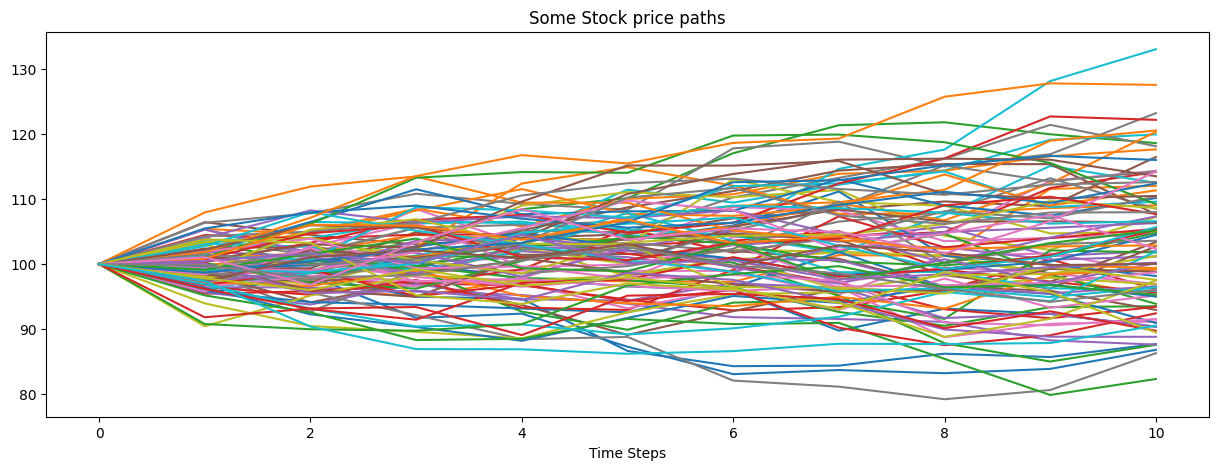

In [26]:
def BS_asset(r , sigma , T , S0 , K ,N ,n):
    dt = T/N # time step
    df = np.exp(-r*dt) # discount factor
    S = torch.zeros(N+1, n) # matrix to store stock prices
    S[0] = S0 # initial stock price
    for t in range(1, N+1):
        z = torch.randn(n) # random numbers
        S[t] = S[t-1]*torch.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z) # stock price process
    return S

S = BS_asset(r , sigma , T , S0 , K ,N ,M)
plt.figure(figsize=(15, 5))
plt.plot(S[: , :100])
plt.title("Some Stock price paths")
plt.xlabel("Time Steps")
plt.show()

In [34]:
def theta_by_mlp(payoff, x, epochs=500, lr=0.01,verbose= False):
    # Convert and reshape inputs for PyTorch
    payoff = torch.tensor(payoff, dtype=torch.float32).view(-1, 1)
    x = torch.tensor(x, dtype=torch.float32).view(-1, 1)

    # Standardize features
    x_mean, x_std = x.mean(), x.std()
    x = (x - x_mean) / (x_std + 1e-8)

    model = nn.Sequential(
        nn.Linear(1, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    ).to(device)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    x, payoff = x.to(device), payoff.to(device)
    for epoch in range(epochs):
        y_pred = model(x)
        loss = loss_fn(y_pred, payoff)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0 and verbose:
            print(f"Epoch {epoch}: Loss = {loss.item()}")

    return model, x_mean, x_std

def function_Phi_mlp(x, model, x_mean, x_std):
    x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
    x_tensor = (x_tensor - x_mean) / (x_std + 1e-8)  # Standardize with training mean and std
    x_tensor = x_tensor.to(device)
    with torch.no_grad():
        output = model(x_tensor)
    return output

def backward_recursion_nn(S , K , r , sigma , T , N , df ,verbose= False):
    C = np.maximum(K -S[-1], 0) # option price at maturity
    models = [None]*N
    means = np.zeros(N)
    stds = np.zeros(N)
    for t in range(N-1, 0, -1):  # Backward induction
        x = S[t]
        y = C*df
        model, mean, std = theta_by_mlp(y, x,verbose= verbose)
        models[t] = model
        means[t] = mean
        stds[t] = std
        continuation = function_Phi_mlp(x, model, mean, std).flatten()
        exercise = (K - S[t]).flatten()  # This is a NumPy operation so keep it as a NumPy array
        exercisable = np.where(exercise > continuation)
        non_exercisable = np.where(exercise <= continuation)
        C[exercisable] = exercise[exercisable]
        C[non_exercisable] =  C[non_exercisable]*df
    return C , models , means , stds

C , models , means , stds = backward_recursion_nn(S , K , r , sigma , T , N , df , verbose= True)


<ipython-input-34-7a318970c408>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  payoff = torch.tensor(payoff, dtype=torch.float32).view(-1, 1)
<ipython-input-34-7a318970c408>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).view(-1, 1)


Epoch 0: Loss = 22.205869674682617
Epoch 100: Loss = 2.7317700386047363
Epoch 200: Loss = 2.7150330543518066
Epoch 300: Loss = 2.7144980430603027
Epoch 400: Loss = 2.7142364978790283


<ipython-input-34-7a318970c408>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)


Epoch 0: Loss = 24.909677505493164
Epoch 100: Loss = 3.160571575164795
Epoch 200: Loss = 3.127598285675049
Epoch 300: Loss = 3.125995397567749
Epoch 400: Loss = 3.1256515979766846
Epoch 0: Loss = 22.976730346679688
Epoch 100: Loss = 3.8706352710723877
Epoch 200: Loss = 3.636852741241455
Epoch 300: Loss = 3.625627279281616
Epoch 400: Loss = 3.6242237091064453
Epoch 0: Loss = 21.468360900878906
Epoch 100: Loss = 4.2924723625183105
Epoch 200: Loss = 4.267760753631592
Epoch 300: Loss = 4.266970157623291
Epoch 400: Loss = 4.266180515289307
Epoch 0: Loss = 21.108661651611328
Epoch 100: Loss = 5.158486366271973
Epoch 200: Loss = 5.1366424560546875
Epoch 300: Loss = 5.135356426239014
Epoch 400: Loss = 5.134306907653809
Epoch 0: Loss = 22.65224266052246
Epoch 100: Loss = 6.639259338378906
Epoch 200: Loss = 6.4469451904296875
Epoch 300: Loss = 6.403118133544922
Epoch 400: Loss = 6.382712364196777
Epoch 0: Loss = 19.824007034301758
Epoch 100: Loss = 7.859940528869629
Epoch 200: Loss = 7.821384429

In [35]:
print(f"Option price: {C.mean()} +/- {C.std()/np.sqrt(M)}")

Option price: 2.6366965770721436 +/- 0.011012873612344265


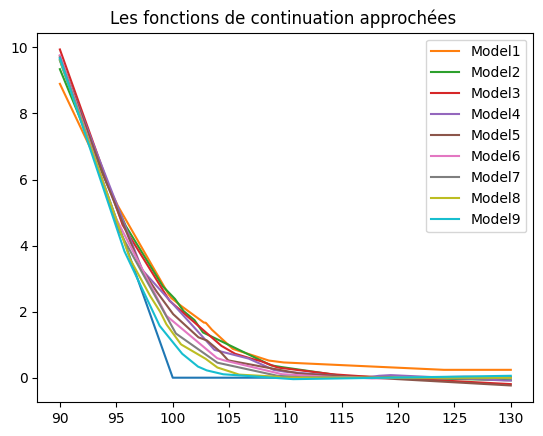

In [36]:
def payoff_phi(n, x):
    return np.exp(-r*n*T/N) * np.maximum(K-x, 0)
xx = np.linspace(90, 130, 1000)

fig, ax = plt.subplots()
ax.plot(xx, payoff_phi(N, xx))
for n in range(1, N):
    ax.plot(xx, function_Phi_mlp(xx, models[n] , means[n] , stds[n]), label=fr"Model{n}")
    ax.legend()
    ax.set_title("Les fonctions de continuation approchées ")
plt.show()

<ipython-input-34-7a318970c408>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  payoff = torch.tensor(payoff, dtype=torch.float32).view(-1, 1)
<ipython-input-34-7a318970c408>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).view(-1, 1)
<ipython-input-34-7a318970c408>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)


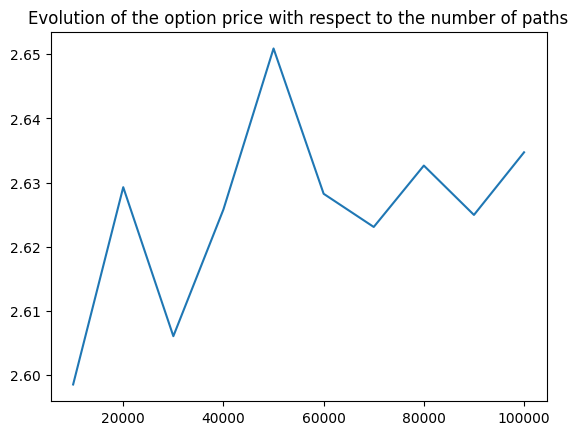

In [37]:
# evolution of the option price with respect to the number of paths
M = 100000
N = 10
prix = []
variance = []

for m in range(10000, M+1, 10000):
    S = BS_asset(r , sigma , T , S0 , K ,N ,m)
    C , models , means , stds = backward_recursion_nn(S , K , r , sigma , T , N , df)
    C = C.numpy()
    prix.append(np.mean(C*df))
    variance.append(np.std(C*df))

plt.plot(range(10000, M+1, 10000), prix)
plt.title("Evolution of the option price with respect to the number of paths")
plt.show()


<ipython-input-34-7a318970c408>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  payoff = torch.tensor(payoff, dtype=torch.float32).view(-1, 1)
<ipython-input-34-7a318970c408>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).view(-1, 1)
<ipython-input-34-7a318970c408>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)


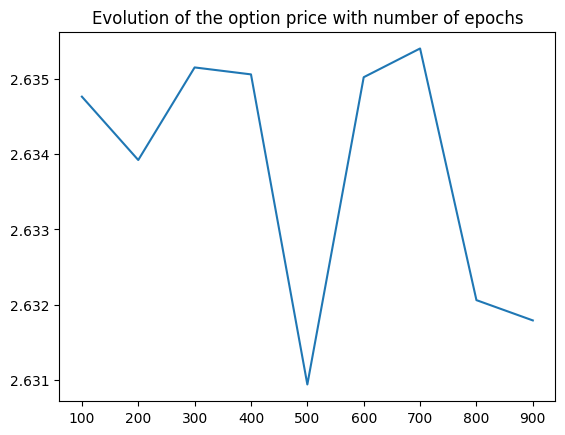

In [39]:
# evolution of the option price with number of epochs
prix = []
variance = []

for n in range(100, 1000, 100):
    C , models , means , stds = backward_recursion_nn(S , K , r , sigma , T , N , df)
    C = C.numpy()
    prix.append(np.mean(C*df))

plt.plot(range(100, 1000, 100), prix)
plt.title("Evolution of the option price with number of epochs")
plt.show()
